# Beta Factors

This notebook will investigate the use of $\beta$ of commoditiy futures as a way for deciling and generating factors. In this case the PCA was run via the breakeven curve and the inflation swap curve. 

## Packages

In [4]:
import os
import sys 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

Accessing Objects

In [6]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CommodityInflationFactor/root/src")
from BreakevenPCABetaFactor import BreakevenPCABetaFactor
from InflationSwapPCABetaFactor import InflationSwapPCABetaFactor

## Geta Data

In [8]:
def get_data() -> pd.DataFrame: 

    df_breakeven = (BreakevenPCABetaFactor().generate_monthly_factor().melt(
        id_vars = ["date", "pc"]).
        dropna().
        assign(curve = "breakeven"))
    
    df_inflation = (InflationSwapPCABetaFactor().generate_monthly_factor().melt(
        id_vars = ["date", "pc"]).
        assign(curve = "inflation"))
    
    df_out = pd.concat([df_breakeven, df_inflation])
    return df_out

df_data = get_data()

First plot the returns of each decile

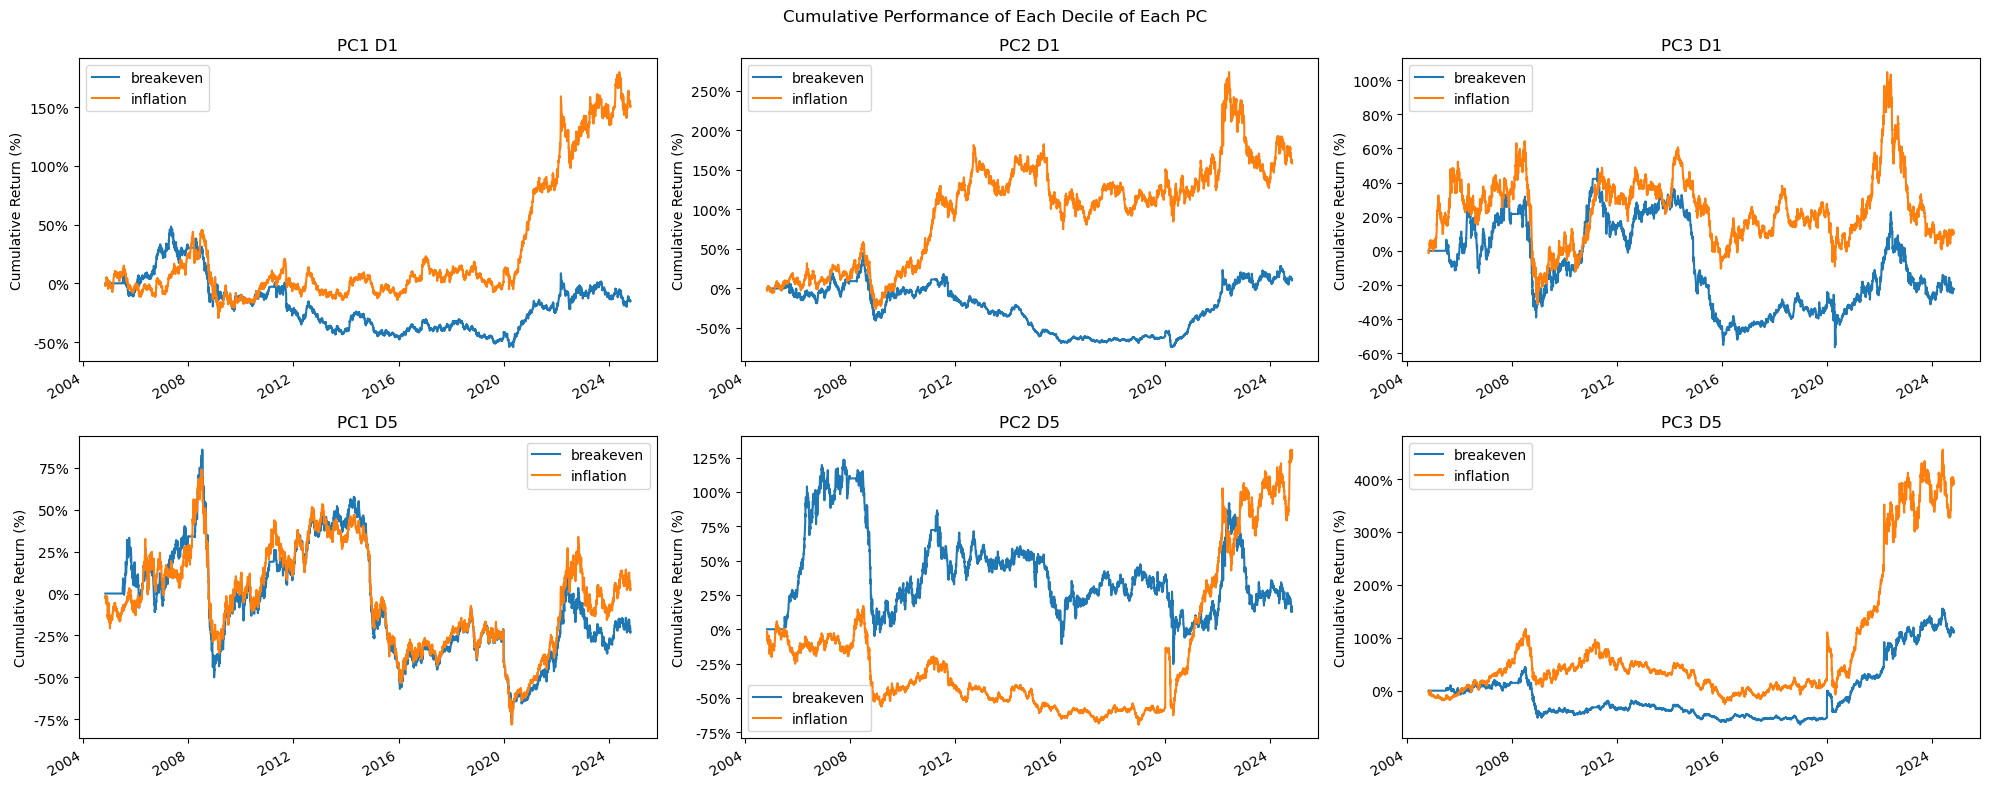

In [10]:
def plot_decile_pc(df_data: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_data.assign(
        group_var = lambda x: x.pc + " " + x.quartile))
    
    group_vars = df_tmp.group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))
    
    for group_var, ax in zip(group_vars, axes.flatten()): 
    
        (df_tmp.query(
            "group_var == @group_var")
            [["date", "value", "curve"]].
            rename(columns = {"curve": ""}).
            pivot(index = "date", columns = "", values = "value").
            fillna(0).
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                xlabel = "",
                title  = group_var,
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
    fig.suptitle("Cumulative Performance of Each Decile of Each PC")
    plt.tight_layout()

plot_decile_pc(df_data)

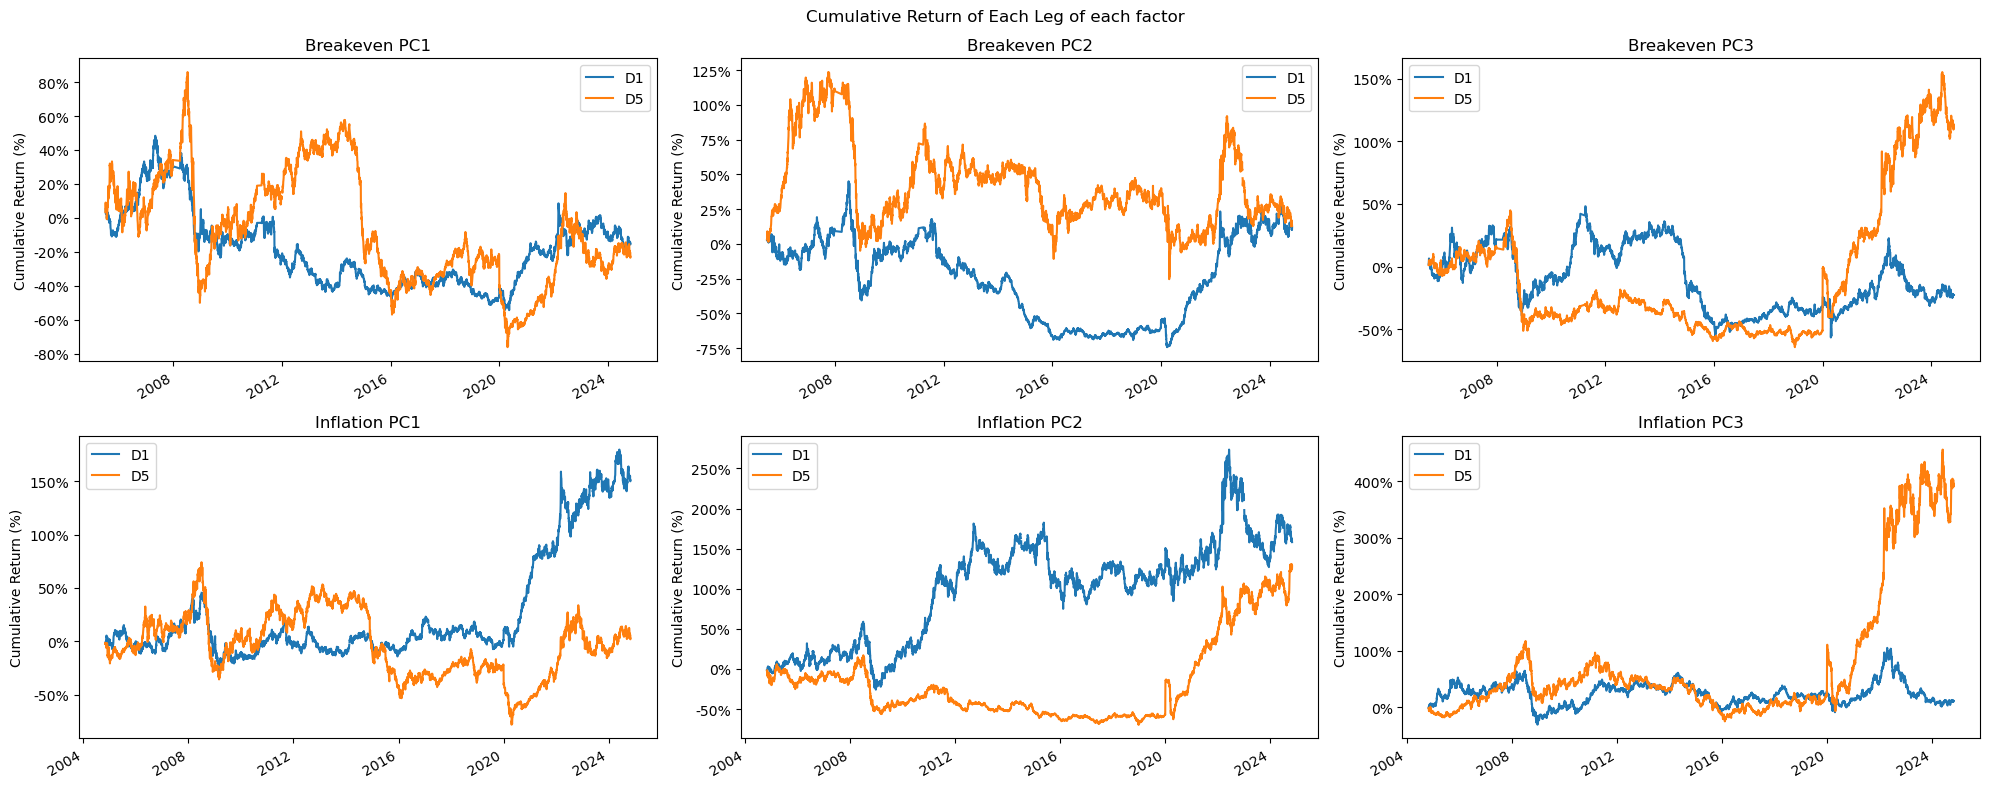

In [11]:
def plot_pc_legs(df_data: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_data.assign(
        group_var = lambda x: x.curve.str.capitalize() + " " + x.pc))
    
    group_vars = df_tmp.group_var.drop_duplicates().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 3, figsize = (20,8))
    
    for group_var, ax in zip(group_vars, axes.flatten()):
    
        (df_tmp.query(
            "group_var == @group_var")
            [["date", "value", "quartile"]].
            rename(columns = {"quartile": ""}).
            pivot(index = "date", columns = "", values = "value").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = group_var,
                ylabel = "Cumulative Return (%)",
                xlabel = ""))
    
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
    fig.suptitle("Cumulative Return of Each Leg of each factor")
    plt.tight_layout()

plot_pc_legs(df_data)

## Generate Dollar Neutral Factor

Start by generating dollar neutral factor returns

In [14]:
def generate_dollar_neutral_factor_d1d5(df_data: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_data.pivot(
        index = ["date", "pc", "curve"], columns = "quartile", values = "value").
        reset_index().
        assign(
            D1 = lambda x: x.D1.fillna(x.D5),
            D5 = lambda x: x.D5.fillna(x.D1)).
        assign(spread = lambda x: x.D1 - x.D5))

    return df_out

df_factor = generate_dollar_neutral_factor_d1d5(df_data)

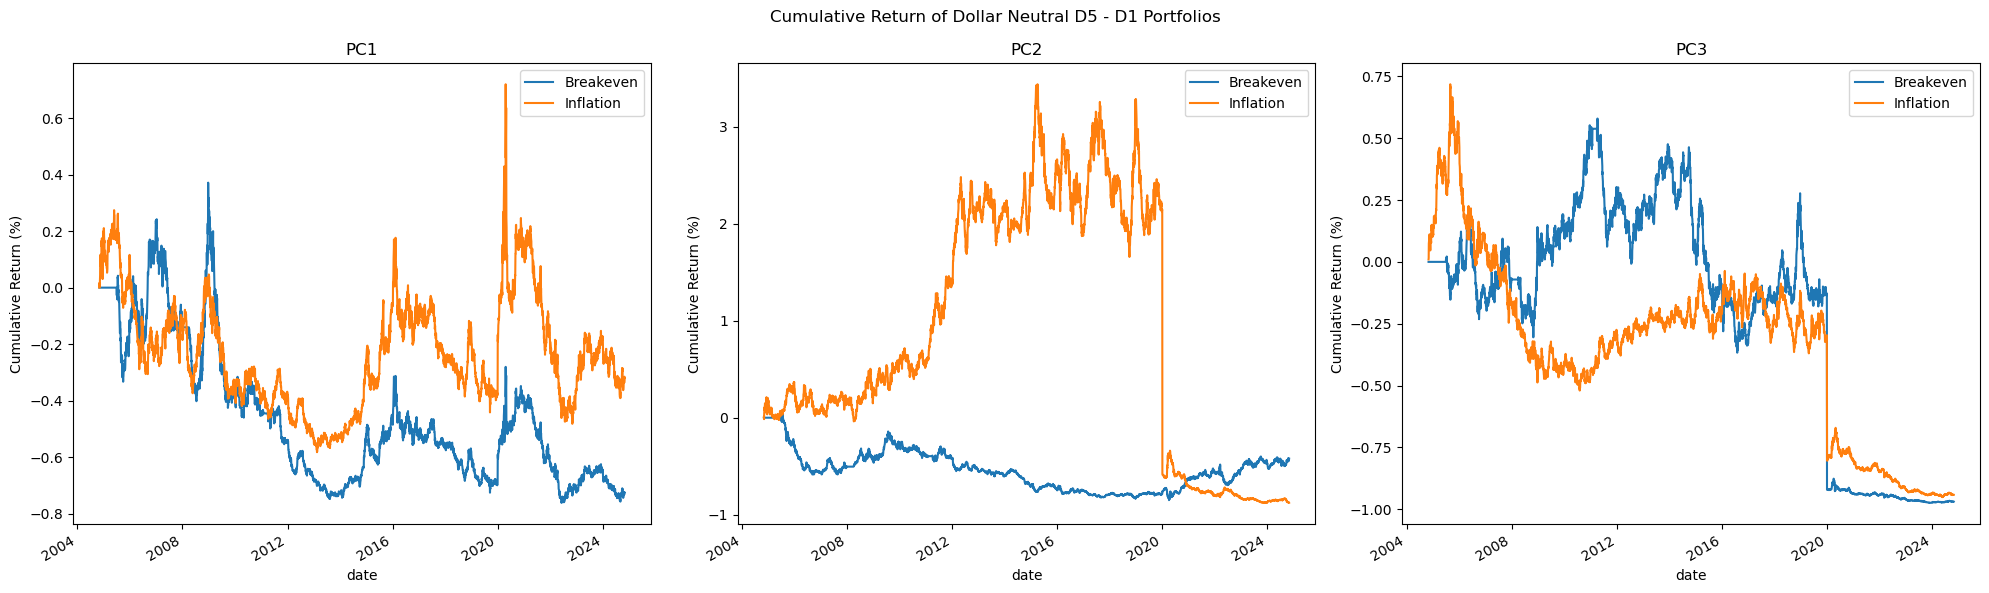

In [15]:
def plot_dollar_neutral_factor_d1d5(df_data: pd.DataFrame) -> pd.DataFrame: 

    pcs       = df_factor.pc.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (20,6))
    
    for pc, ax in zip(pcs, axes.flatten()):
    
        (df_factor.query(
            "pc == @pc")
            [["date", "curve", "spread"]].
            assign(curve = lambda x: x.curve.str.capitalize()).
            rename(columns = {"curve": ""}).
            pivot(index = "date", columns = "", values = "spread").
            fillna(0).
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = pc,
                ylabel = "Cumulative Return (%)"))
    
    fig.suptitle("Cumulative Return of Dollar Neutral D5 - D1 Portfolios")
    plt.tight_layout()

plot_dollar_neutral_factor_d1d5(df_data)

In [16]:
def generate_dollar_neutral_factor_d5d1(df_data: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_data.pivot(
        index = ["date", "pc", "curve"], columns = "quartile", values = "value").
        reset_index().
        assign(
            D1 = lambda x: x.D1.fillna(x.D5),
            D5 = lambda x: x.D5.fillna(x.D1)).
        assign(spread = lambda x: x.D5 - x.D1))

    return df_out

df_factor = generate_dollar_neutral_factor_d5d1(df_data)

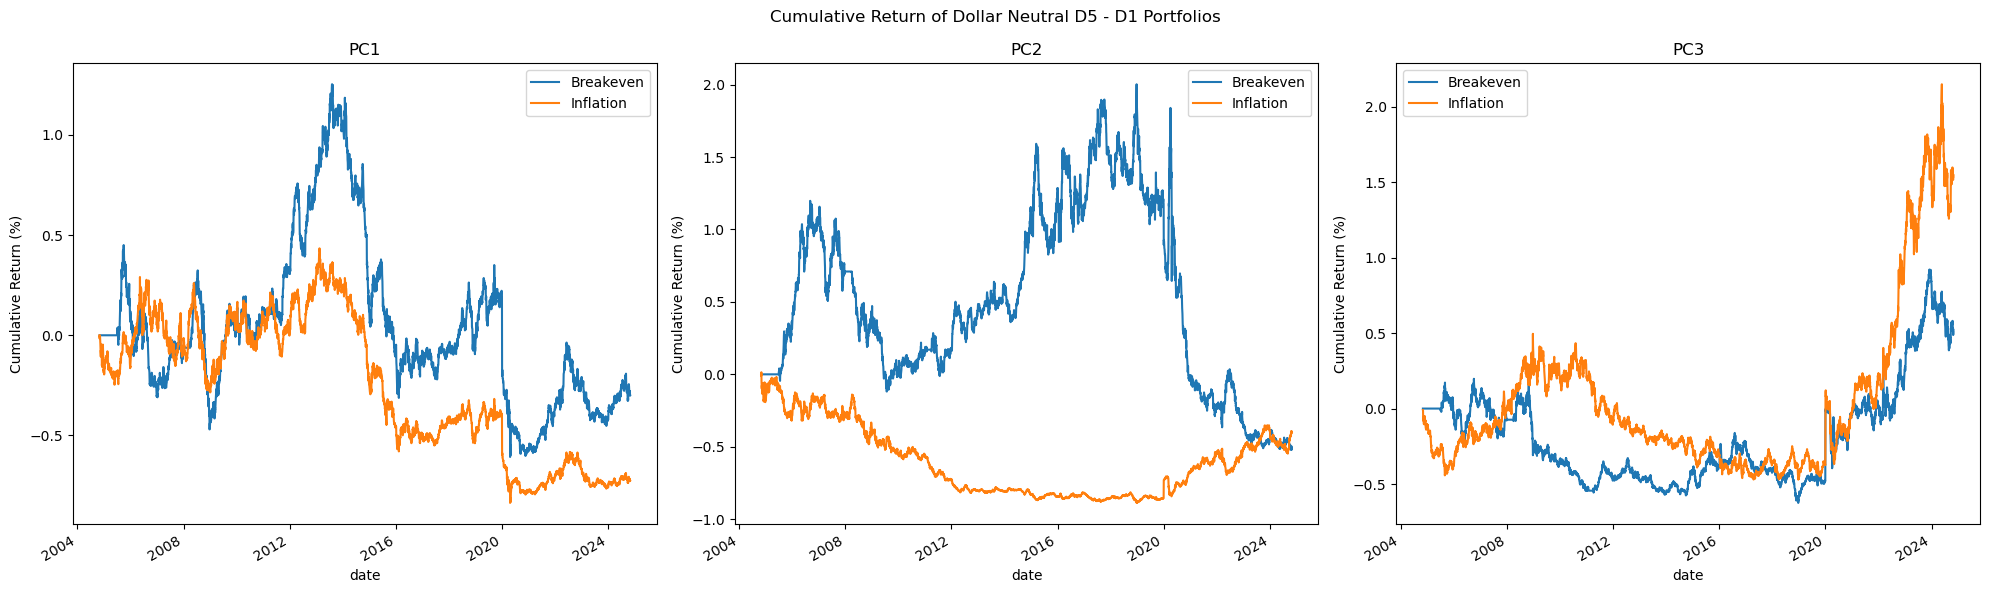

In [17]:
def plot_dollar_neutral_factor_d5d1(df_data: pd.DataFrame) -> pd.DataFrame: 

    pcs       = df_factor.pc.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(pcs), figsize = (20,6))
    
    for pc, ax in zip(pcs, axes.flatten()):
    
        (df_factor.query(
            "pc == @pc")
            [["date", "curve", "spread"]].
            assign(curve = lambda x: x.curve.str.capitalize()).
            rename(columns = {"curve": ""}).
            pivot(index = "date", columns = "", values = "spread").
            fillna(0).
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = pc,
                ylabel = "Cumulative Return (%)"))
    
    fig.suptitle("Cumulative Return of Dollar Neutral D1 - D5 Portfolios")
    plt.tight_layout()

plot_dollar_neutral_factor_d1d5(df_data)

## Performance Attributes

In [19]:
def get_sharpe() -> pd.DataFrame: 

    df_out = (pd.concat([
        generate_dollar_neutral_factor_d5d1(df_data).assign(spread_type = "d5d1"),
        generate_dollar_neutral_factor_d1d5(df_data).assign(spread_type = "d1d5")]))
    
    df_sharpe = (df_out[
        ["pc", "curve", "spread_type", "spread"]].
        groupby(["pc", "curve", "spread_type"]).
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_sharpe

df_sharpe = get_sharpe()

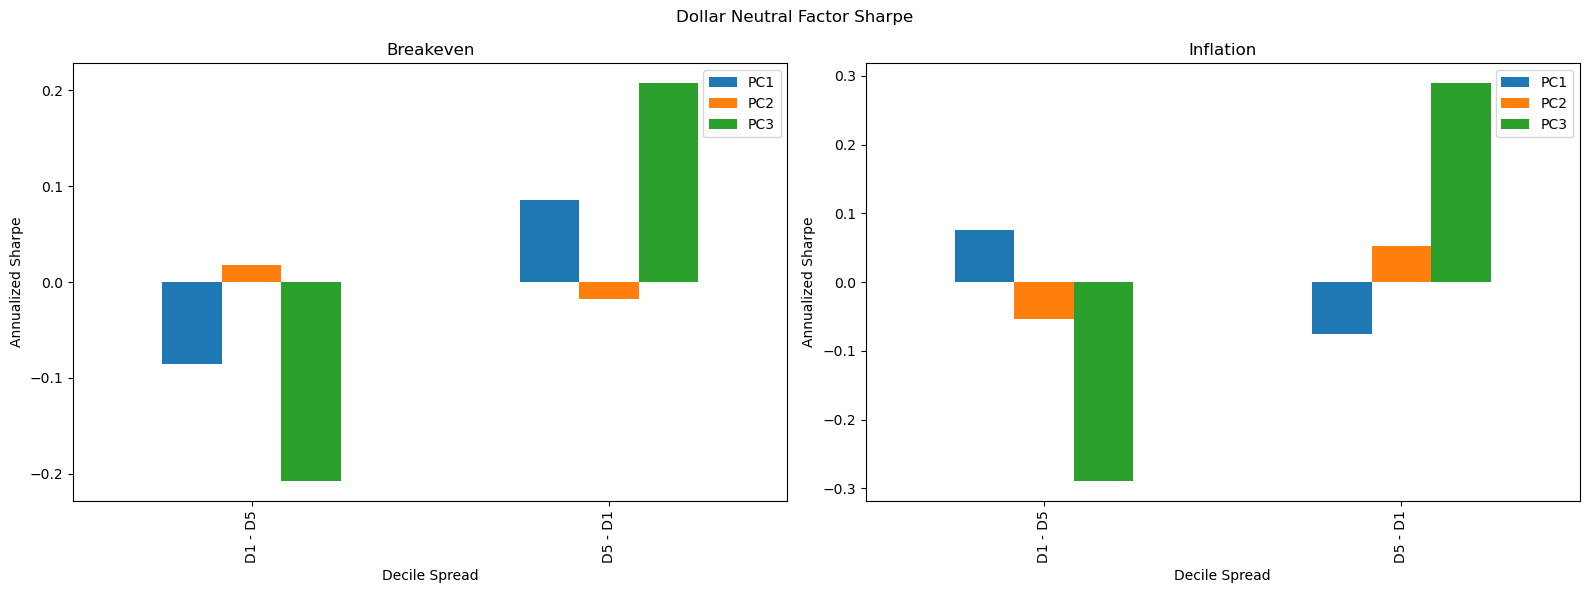

In [20]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_sharpe[
        ["pc", "curve", "spread_type", "sharpe"]].
        assign(
            curve = lambda x: x.curve.str.capitalize(),
            spread_type = lambda x: np.where(x.spread_type == "d1d5", "D1 - D5", "D5 - D1")))
    
    variables = df_tmp.curve.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (16,6))
    
    for variable, ax in zip(variables, axes.flatten()): 
    
        (df_tmp.query(
            "curve == @variable").
            drop(columns = ["curve"]).
            rename(columns = {"pc": ""}).
            pivot(index = "spread_type", columns = "", values = "sharpe").
            plot(
                kind   = "bar",
                ax     = ax,
                ylabel = "Annualized Sharpe",
                title  = variable,
                xlabel = "Decile Spread"))
    
    fig.suptitle("Dollar Neutral Factor Sharpe")
    plt.tight_layout()

plot_sharpe(df_sharpe)

It appears that these sharpes are not tradable. Even if there is a way to parse out which is the correct way to trade the deciles they do not generate substantial enough sharpes to make money as they sit around ~0.2 at best. 

In [22]:
def get_decile_sharpe(df_data: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df_data.drop(
        columns = ["date"]).
        groupby(["pc", "quartile", "curve"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_out

df_decile_sharpe = get_decile_sharpe(df_data)

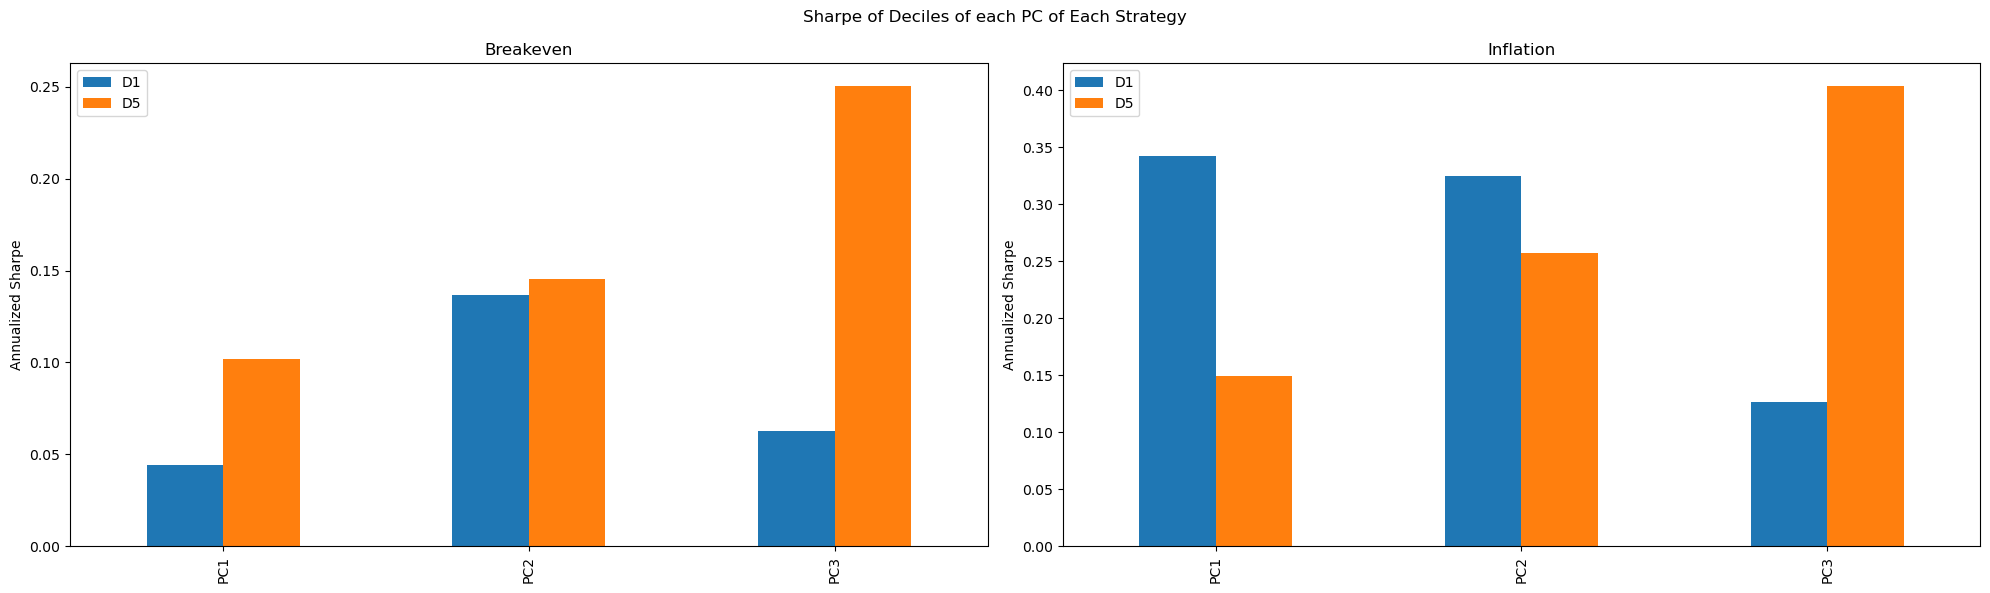

In [23]:
def plot_decile_sharpe(df_decile_sharpe: pd.DataFrame) -> plt.Figure: 

    df_tmp = (df_decile_sharpe.assign(
        curve = lambda x: x.curve.str.capitalize()))
    
    group_vars = df_tmp.curve.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars), figsize = (20,6))
    
    for group_var, ax in zip(group_vars, axes.flatten()): 
    
        (df_tmp.query(
            "curve == @group_var")
            [["pc", "quartile", "sharpe"]].
            rename(columns = {"quartile": ""}).
            pivot(index = "pc", columns = "", values = "sharpe").
            plot(
                ax     = ax,
                kind   = "bar",
                ylabel = "Annualized Sharpe",
                xlabel = "",
                title  = group_var))
    
    fig.suptitle("Sharpe of Deciles of each PC of Each Strategy")
    plt.tight_layout()

plot_decile_sharpe(df_decile_sharpe)